#### Baseline correction based on the code of eBASCO 
- no filter 
- preserve the permanant displacement

nessuna soluzione per UD
f value EW:  9633
f value NS:  13481

------------PERMANENT DISPLACEMENT--------------
permanent displacement EW [cm]:  34.72
permanent displacement NS [cm]:  68.25
permanent displacement UD [cm]:  -999.00
---------------------------------------------



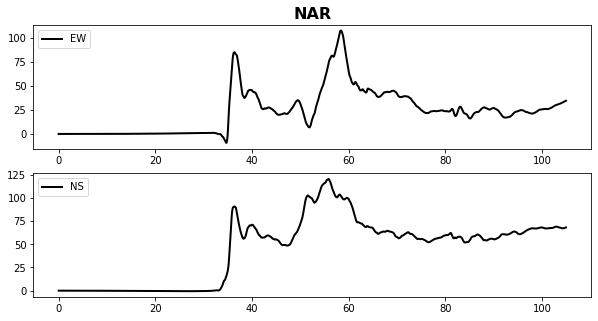

In [34]:
from obspy import read
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange, gradient, concatenate, argmax # (numpy==1.16.2)
from funclib_eBASCO import post_eve, retta, post_eve_detrend, strong_eve, strong_eve_detrend, fvalue, final_trace, pre_eve,\
    ACCtoDISP, sample_T1, sample_T2, sample_T3, end_point, accept_solution, acc_corr, pre_eve_detrend, dpcpy_Stream

#-----------------    
# input: number of T1, T2, T3 correction points samples (default)
#-----------------
t1 = 5
t2 = 20
t3 = 20
eps = 0.25

# read raw data
sta = 'NAR'
st_E = read("TK_unprocess/TK." + str(sta) + "..HNE.INT-20230206_0000008.ACC.CV.mseed")
st_N = read("TK_unprocess/TK." + str(sta) + "..HNN.INT-20230206_0000008.ACC.CV.mseed")
st_Z = read("TK_unprocess/TK." + str(sta) + "..HNZ.INT-20230206_0000008.ACC.CV.mseed")

dur_e = st_E[0].stats.endtime - st_E[0].stats.starttime
dur_n = st_N[0].stats.endtime - st_N[0].stats.starttime
dur_z = st_Z[0].stats.endtime - st_Z[0].stats.starttime
dur_min = min(dur_e, dur_n, dur_z)
npts_max = max(st_E[0].stats.npts, st_N[0].stats.npts, st_Z[0].stats.npts)
dt_e = st_E[0].stats.delta
dt_n = st_N[0].stats.delta
dt_z = st_Z[0].stats.delta

WF_CUT = ACCtoDISP(st_E, st_N, st_Z, dt_e, dt_n, dt_z)

# sample the T1 time before the 5% of the cumulated energy (ARIAS INTENSITY)
T1_SAMPLES = sample_T1(WF_CUT[0][0], WF_CUT[0][1], WF_CUT[0][2], dt_e, dt_n, dt_z, t1)

# define the "pre-event" between the first sample T0 and T1  (velocity)
[PRE_EVE_TIME, PRE_EVE_VEL] = pre_eve(WF_CUT[1][0], WF_CUT[1][1], WF_CUT[1][2], dt_e, dt_n, dt_z, T1_SAMPLES)

# linear de-trend in the "pre-event"
PRE_EVE_VEL_DET, LAST_VALUE_LIN_FIT, LIN_FIT = pre_eve_detrend(PRE_EVE_TIME,PRE_EVE_VEL)

# sample T3 time after the 5% of the cumulated energy (ARIAS INTENSITY)
T3_SAMPLES = sample_T3(WF_CUT[0][0],WF_CUT[0][1],WF_CUT[0][2], dt_e, dt_n, dt_z, t3)

# search the end points for each component
END_POINTS = end_point(WF_CUT[0][0], WF_CUT[0][1], WF_CUT[0][2], dt_e, dt_n, dt_z)

T1_E = []; T2_E = []; T3_E = []; TIME_E=[]; VEL_CORR_E=[]
T1_N = []; T2_N = []; T3_N = []; TIME_N=[]; VEL_CORR_N=[]
T1_Z = []; T2_Z = []; T3_Z = []; TIME_Z=[]; VEL_CORR_Z=[]

# memory_usage = psutil.virtual_memory()
# while time.time() < stop_time:
# while memory_usage.percent < 75:
for index_T1 in arange(len(T1_SAMPLES[0])-int(len(T1_SAMPLES[0])/2)):
    for index_T3 in arange(len(T3_SAMPLES[0])-int(len(T3_SAMPLES[0])/2)):                               
        # sample T2 time from each T3 and the end of the signal
        T2_SAMPLES = sample_T2(T3_SAMPLES,END_POINTS,index_T3, t2)
                  
        for index_T2 in arange(len(T2_SAMPLES[0])-int(len(T2_SAMPLES[0])/2)): 
                        
            # define the "post event" between T2 and the end of the signal (velocity)
            [POST_EVE_TIME, POST_EVE_VEL] = post_eve(WF_CUT[1][0],WF_CUT[1][1],WF_CUT[1][2], 
                                                     dt_e, dt_n, dt_z,T2_SAMPLES,END_POINTS,index_T2)  
            # linear de-trend between T2 and the end of the signal (velocity)
            [POST_EVE_VEL_DET, POST_EVE_LIN_FIT] = post_eve_detrend(POST_EVE_TIME,POST_EVE_VEL)
            # define the "strong-event" between T1 and T2 (velocity)                   
            [STRONG_PHASE_TIME, STRONG_PHASE_VEL] = strong_eve(WF_CUT[1][0],WF_CUT[1][1],WF_CUT[1][2], 
                                                               dt_e, dt_n, dt_z,T1_SAMPLES,T2_SAMPLES,index_T1,index_T2)
            
            # calculate the slope Am of the line between V(T1) and V(T2); 
            # V(T1) and V(T2) are the last point of the detrending line in the "pre-event" 
            # and the first point of the detrending line in the "post-event", respectively
            Am_E = float((POST_EVE_LIN_FIT[0][0]-LAST_VALUE_LIN_FIT[0][index_T1])/(T2_SAMPLES[0][index_T2]-T1_SAMPLES[0][index_T1]))
            Am_N = float((POST_EVE_LIN_FIT[1][0]-LAST_VALUE_LIN_FIT[1][index_T1])/(T2_SAMPLES[1][index_T2]-T1_SAMPLES[1][index_T1]))
            Am_Z = float((POST_EVE_LIN_FIT[2][0]-LAST_VALUE_LIN_FIT[2][index_T1])/(T2_SAMPLES[2][index_T2]-T1_SAMPLES[2][index_T1]))
            # calculate the ordinate intercept of the line between V(T1) and V(T2)
            q_E = LAST_VALUE_LIN_FIT[0][index_T1] - Am_E*T1_SAMPLES[0][index_T1]
            q_N = LAST_VALUE_LIN_FIT[1][index_T1] - Am_N*T1_SAMPLES[1][index_T1]
            q_Z = LAST_VALUE_LIN_FIT[2][index_T1] - Am_Z*T1_SAMPLES[2][index_T1]
            
            # define the detrending line between V(T1) and V(T2)                        
            STRONG_PHASE_LINE = [retta(STRONG_PHASE_TIME[0],Am_E,q_E), retta(STRONG_PHASE_TIME[1],Am_N,q_N), retta(STRONG_PHASE_TIME[2],Am_Z,q_Z)]
            # linear de-trend in the "strong-event" 
            STRONG_PHASE_VEL_DET = strong_eve_detrend(STRONG_PHASE_TIME,STRONG_PHASE_VEL,STRONG_PHASE_LINE)
            
            # concatenate the trilinear detrended velocity trace (time windows start-T1, T1-T2, T3-Tend)
            TIME_E.append(concatenate((PRE_EVE_TIME[0][index_T1],STRONG_PHASE_TIME[0],POST_EVE_TIME[0][1:]),axis=0))
            VEL_CORR_E.append(concatenate((PRE_EVE_VEL_DET[0][index_T1],STRONG_PHASE_VEL_DET[0],POST_EVE_VEL_DET[0][1:]),axis=0))                                           
            TIME_N.append(concatenate((PRE_EVE_TIME[1][index_T1],STRONG_PHASE_TIME[1],POST_EVE_TIME[1][1:]),axis=0))
            VEL_CORR_N.append(concatenate((PRE_EVE_VEL_DET[1][index_T1],STRONG_PHASE_VEL_DET[1],POST_EVE_VEL_DET[1][1:]),axis=0)) 
            
            TIME_Z.append(concatenate((PRE_EVE_TIME[2][index_T1],STRONG_PHASE_TIME[2],POST_EVE_TIME[2][1:]),axis=0))
            VEL_CORR_Z.append(concatenate((PRE_EVE_VEL_DET[2][index_T1],STRONG_PHASE_VEL_DET[2],POST_EVE_VEL_DET[2][1:]),axis=0))    
            
            T1_E.append(T1_SAMPLES[0][index_T1]); T1_N.append(T1_SAMPLES[1][index_T1]); T1_Z.append(T1_SAMPLES[2][index_T1])                 
            T2_E.append(T2_SAMPLES[0][index_T2]); T2_N.append(T2_SAMPLES[1][index_T2]); T2_Z.append(T2_SAMPLES[2][index_T2])
            T3_E.append(T3_SAMPLES[0][index_T3]); T3_N.append(T3_SAMPLES[1][index_T3]); T3_Z.append(T3_SAMPLES[2][index_T3])

#---------------------------------------
# DIFFERENTIATE THE VELOCITY
#---------------------------------------
# differentiate the corrected velocity to obtaine the acceleration
strms = dpcpy_Stream(VEL_CORR_E, VEL_CORR_N, VEL_CORR_Z) # make a copy of the velocity stream for each component
ACC_CORR_E = []; ACC_CORR_N = []; ACC_CORR_Z = []
for ind in arange(len(strms[0])):
    ACC_CORR_E.append(gradient(strms[0][ind],dt_e))
for ind in arange(len(strms[1])):
    ACC_CORR_N.append(gradient(strms[1][ind],dt_n))
for ind in arange(len(strms[2])):
    ACC_CORR_Z.append(gradient(strms[2][ind],dt_z))
    
#--------------------------------------------
# CHECK THE OPTS.T1*OPTS.T2*OPTS.T3 SOLUTIONS
#--------------------------------------------
# print("--> check what solutions are acceptable")
#
# check what solutions satisfy the treshold between ACC_RAW and ACC_eBASCO in T1 and T2; 
# the default treshold corresponds to the 25% of the difference between ACC_RAW and ACC_eBASCO in T1 and T2 (absolute value)
[ACC_CORR_E_good,ACC_bad_E,T3_E_good,INDEX_good_E] = acc_corr(WF_CUT[0][0], ACC_CORR_E, dt_e, T1_E, T2_E, T3_E, eps)             
[ACC_CORR_N_good,ACC_bad_N,T3_N_good,INDEX_good_N] = acc_corr(WF_CUT[0][1], ACC_CORR_N, dt_n, T1_N, T2_N, T3_N, eps)
[ACC_CORR_Z_good,ACC_bad_Z,T3_Z_good,INDEX_good_Z] = acc_corr(WF_CUT[0][2], ACC_CORR_Z, dt_z, T1_Z, T2_Z, T3_Z, eps)             

# print("--> calculate VEL and DISP for each acceptable ACC") 
#           
# calculate VEL and DISP for each acceptable ACC
[TIME_E_good, VEL_CORR_E_good, DISP_CORR_E_good] = accept_solution(ACC_CORR_E_good, dt_e, 'EW')
[TIME_N_good, VEL_CORR_N_good, DISP_CORR_N_good] = accept_solution(ACC_CORR_N_good, dt_n, 'NS')
[TIME_Z_good, VEL_CORR_Z_good, DISP_CORR_Z_good] = accept_solution(ACC_CORR_Z_good, dt_z, 'UD')

# to calculate the flatness indicator
# ----------------------------------#
# r = linear correlation coefficient of the samples between T3 and the end of the signal 
#     --> -1<= r <=1   if |r|=1 good linear covariance
# b = slope of the regression line between T3 and the end of the signal 
#     --> 0 when the [T3:end] signal is costant
# sigma = variance of the mean value of the samples between T3 and the end of the signal 
#     --> sigma-->0 means that the samples are poor scattered around the mean value
# f_value = |r|/(|b|*sigma) is the flatness indicator f
#     --> high value when the signal between T3 and the end of the signal approssimates a line parallel to the time axes
#----------------------------------#

# print("--> identify the best solution througth the flatness indicator")
# print("------------FLATNESS INDICATORS--------------")       

st_E_dis=[-999]; st_N_dis=[-999]; st_Z_dis=[-999]

if len(ACC_CORR_E_good)>0: f_value_E = []; f_value_E = fvalue(TIME_E_good,DISP_CORR_E_good,T3_E_good); num_E = argmax(f_value_E);\
    [st_E_acc, st_E_vel, st_E_dis] = final_trace(ACC_CORR_E_good,num_E, 5, dt_e, 2, 35); \
        print("f value EW: ",format(f_value_E[num_E],'.0f')); \
            T1_E_good = T1_E[num_E]; T2_E_good = T2_E[num_E]; T3_E_good = T3_E[num_E];
else: num_E = -999; st_E_acc=[0]
if len(ACC_CORR_N_good)>0: f_value_N = []; f_value_N = fvalue(TIME_N_good,DISP_CORR_N_good,T3_N_good); num_N = argmax(f_value_N);\
    [st_N_acc, st_N_vel, st_N_dis] = final_trace(ACC_CORR_N_good,num_N, 5, dt_n, 2, 35); \
        print("f value NS: ",format(f_value_N[num_N],'.0f')); \
            T1_N_good = T1_N[num_N]; T2_N_good = T2_N[num_N]; T3_N_good = T3_N[num_N];
else: num_N = -999; st_N_acc=[0]
if len(ACC_CORR_Z_good)>0: f_value_Z = []; f_value_Z = fvalue(TIME_Z_good,DISP_CORR_Z_good,T3_Z_good); num_Z = argmax(f_value_Z);\
    [st_Z_acc, st_Z_vel, st_Z_dis] = final_trace(ACC_CORR_Z_good,num_Z, 5, dt_z, 2, 35); \
        print("f value UD: ",format(f_value_Z[num_Z],'.0f')); T1_Z_good = T1_Z[num_Z]; \
            T2_Z_good = T2_Z[num_Z]; T3_Z_good = T3_Z[num_Z];
else: num_Z = -999; st_Z_acc=[0]

#--------------------------------------------
# READ THE PERMANET DISPLACEMENT
#--------------------------------------------            
print("")
print("------------PERMANENT DISPLACEMENT--------------") 
EW_pd = st_E_dis[-1]
NS_pd = st_N_dis[-1]
UD_pd = st_Z_dis[-1]
print("permanent displacement EW [cm]: ",format(EW_pd,'.2f'))
print("permanent displacement NS [cm]: ",format(NS_pd,'.2f'))
print("permanent displacement UD [cm]: ",format(UD_pd,'.2f'))
print("---------------------------------------------") 
print("")

#-------------------------------------------#
#				OUTPUT						#
#-------------------------------------------#


#-------------------------------------------#
#				plot						#
#-------------------------------------------#
fig, (H1, H2) = plt.subplots(2, 1, figsize=(10, 5))
H1.set_title(str(sta), fontsize=16, fontweight='bold')
H1.plot(np.arange(st_E_dis.size, dtype=float) * dt_e , st_E_dis, '-k', lw=2, label='EW')
H1.legend(loc='upper left')
H2.plot(np.arange(st_N_dis.size, dtype=float) * dt_n , st_N_dis, '-k', lw=2, label='NS')
H2.legend(loc='upper left')
plt.savefig('OUTPUT/Fling-step_'+ str(sta)+'.png')
plt.show()

#### Fling step removal by Kamai et al. (2014)'s model
- EW component

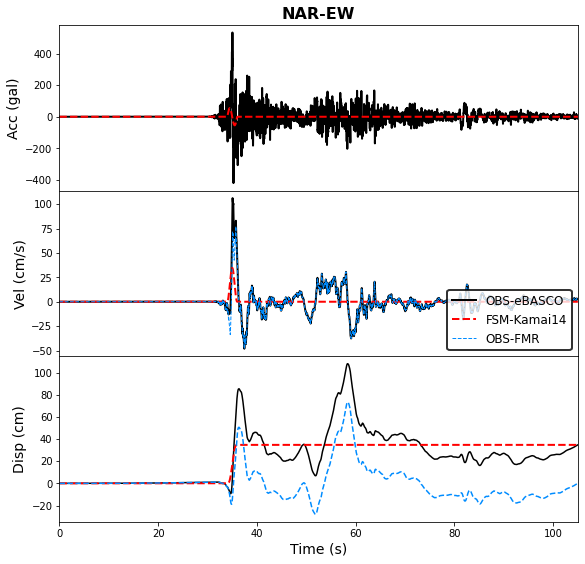

In [35]:
def sub_makefling(samp, TotalTime, t1, Tf, Dsite):
    # TotalTime in s; t1 in s; Tf in s (period); Dsite in cm
    dt = 1 / samp
    t1_pt = round(t1 * samp)
    Tf_pt = round(Tf * samp)
    npts = round(TotalTime * samp)
    time = np.arange(1, npts + 1) * dt
    disp = np.zeros(npts)
    disp[t1_pt:t1_pt + Tf_pt] = ((Dsite / Tf) * (time[t1_pt:t1_pt + Tf_pt] - t1)) \
        - ((Dsite / (2 * np.pi)) * np.sin(((2 * np.pi) / Tf) * (time[t1_pt:t1_pt + Tf_pt] - t1)))
    disp[t1_pt + Tf_pt:] = Dsite
    return time, disp

#---------
# input
#---------
path = 'OUTPUT/2023Turkey/'
comp = 'EW'
dt = dt_e
c3a = st_E_acc # signal amplitude
c1 = np.arange(c3a.size, dtype=float) * dt # time
# modified here by visualize for fling step model
t1 = 34 # t1 is start time of the diaplacement
Tf = 2 # Tf is continuous time period
Dsite = EW_pd # Dsite is the coseismic deformation value

npts = len(c3a)
samp = 1 / dt
tlength = npts / samp

# get velocity and PGV
c3v = np.cumsum(c3a) / samp
# get displacement and CDV
c3d = np.cumsum(c3v) / samp

time_fling, disp_fling = sub_makefling(samp, tlength, t1, Tf, Dsite)
vel_fling = np.diff(disp_fling) * samp
vel_fling = np.concatenate((vel_fling, [vel_fling[-1]]))
acc_fling = np.diff(vel_fling) * samp
acc_fling = np.concatenate((acc_fling, [acc_fling[-1]]))

res_DISP = c3d - disp_fling
vel_res_RMfling = np.diff(res_DISP) * samp
vel_res_RMfling = np.concatenate((vel_res_RMfling, [vel_res_RMfling[-1]]))

#------------------------
# output #vel: cm/s
#------------------------
np.savetxt(path+'TK_'+str(sta)+'VEL_'+str(comp)+'_FRM.txt', vel_res_RMfling)

#------------------------
# plot figure
#------------------------
fig, (H1, H2, H3) = plt.subplots(3, 1, figsize=(12, 10))
H1.plot(c1, c3a, '-k', linewidth=2)
H1.plot(c1, acc_fling, '--r', linewidth=2)
H1.set_title(str(sta)+'-'+str(comp), fontsize=16, fontweight='bold')
H1.set_ylabel('Acc (gal)', fontsize=14)
H1.set_xlim([0, max(c1)])
#H1.text(0.05, 0.8, 'Acc.', transform=H1.transAxes, fontsize=17)

H2.plot(c1, c3v, '-k', linewidth=2)
H2.plot(c1, vel_fling, '--r', linewidth=2)
H2.plot(c1, vel_res_RMfling, '--', color=[0/255, 140/255, 255/255], linewidth=1)
#H2.set_ylim([-50, 70])
H2.set_xlim([0, max(c1)])
H2.set_ylabel('Vel (cm/s)', fontsize=14)
#H2.text(0.05, 0.8, 'Vel.', transform=H2.transAxes, fontsize=17)

H3.plot(c1, c3d, '-k', linewidth=1.5)
H3.plot(time_fling, disp_fling, '--r', linewidth=2)
H3.plot(c1, res_DISP, '--', color=[0/255, 140/255, 255/255], linewidth=1.5)
#H3.plot(c1, cs, '--', color='g', linewidth=1.5)
H3.set_xlim([0, max(c1)])
#H3.set_ylim([-250, 20])
H3.set_ylabel('Disp (cm)', fontsize=14)
H3.set_xlabel('Time (s)', fontsize=14)
#H3.text(0.05, 0.8, 'Dis.', transform=H3.transAxes, fontsize=17)

HL = H2.legend(['OBS-eBASCO','FSM-Kamai14', 'OBS-FMR'], 
               loc='lower right', fontsize=12)
HL.get_frame().set_linewidth(2)
HL.get_frame().set_edgecolor('k')
HL.get_frame().set_facecolor('w')

H1.set_position([0.14, 0.59, 0.6, 0.23])
H1.set_xticklabels([])
H2.set_position([0.14, 0.36, 0.6, 0.23])
H2.set_xticklabels([])
H3.set_position([0.14, 0.13, 0.6, 0.23])
plt.savefig(path+'Fling-step_'+str(sta)+'_'+str(comp)+'.png')
plt.show()

- NS component

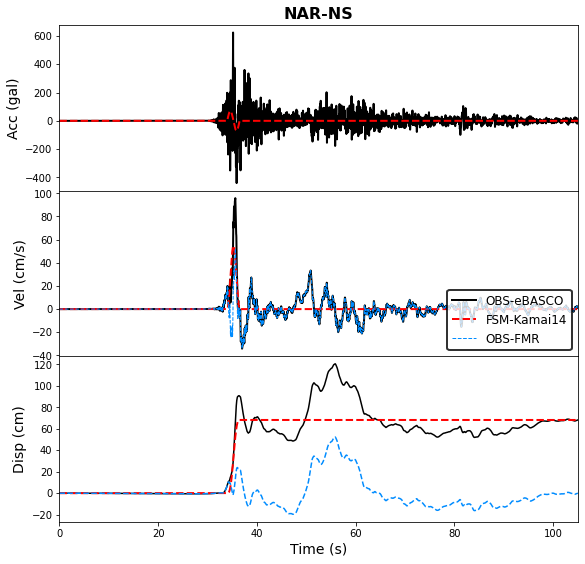

In [36]:
def sub_makefling(samp, TotalTime, t1, Tf, Dsite):
    # TotalTime in s; t1 in s; Tf in s (period); Dsite in cm
    dt = 1 / samp
    t1_pt = round(t1 * samp)
    Tf_pt = round(Tf * samp)
    npts = round(TotalTime * samp)
    time = np.arange(1, npts + 1) * dt
    disp = np.zeros(npts)
    disp[t1_pt:t1_pt + Tf_pt] = ((Dsite / Tf) * (time[t1_pt:t1_pt + Tf_pt] - t1)) \
        - ((Dsite / (2 * np.pi)) * np.sin(((2 * np.pi) / Tf) * (time[t1_pt:t1_pt + Tf_pt] - t1)))
    disp[t1_pt + Tf_pt:] = Dsite
    return time, disp

#---------
# input
#---------
path = 'OUTPUT/2023Turkey/'
comp = 'NS'
dt = dt_e
c3a = st_N_acc # signal amplitude
c1 = np.arange(c3a.size, dtype=float) * dt # time
# modified here by visualize for fling step model
t1 = 34 # t1 is start time of the diaplacement
Tf = 2.5 # Tf is continuous time period
Dsite = NS_pd # Dsite is the coseismic deformation value

npts = len(c3a)
samp = 1 / dt
tlength = npts / samp

# get velocity and PGV
c3v = np.cumsum(c3a) / samp
# get displacement and CDV
c3d = np.cumsum(c3v) / samp

time_fling, disp_fling = sub_makefling(samp, tlength, t1, Tf, Dsite)
vel_fling = np.diff(disp_fling) * samp
vel_fling = np.concatenate((vel_fling, [vel_fling[-1]]))
acc_fling = np.diff(vel_fling) * samp
acc_fling = np.concatenate((acc_fling, [acc_fling[-1]]))

res_DISP = c3d - disp_fling
vel_res_RMfling = np.diff(res_DISP) * samp
vel_res_RMfling = np.concatenate((vel_res_RMfling, [vel_res_RMfling[-1]]))

#------------------------
# output #vel: cm/s
#------------------------
np.savetxt(path+'TK_'+str(sta)+'VEL_'+str(comp)+'_FRM.txt', vel_res_RMfling)

#------------------------
# plot figure
#------------------------
fig, (H1, H2, H3) = plt.subplots(3, 1, figsize=(12, 10))
H1.plot(c1, c3a, '-k', linewidth=2)
H1.plot(c1, acc_fling, '--r', linewidth=2)
H1.set_title(str(sta)+'-'+str(comp), fontsize=16, fontweight='bold')
H1.set_ylabel('Acc (gal)', fontsize=14)
H1.set_xlim([0, max(c1)])
#H1.text(0.05, 0.8, 'Acc.', transform=H1.transAxes, fontsize=17)

H2.plot(c1, c3v, '-k', linewidth=2)
H2.plot(c1, vel_fling, '--r', linewidth=2)
H2.plot(c1, vel_res_RMfling, '--', color=[0/255, 140/255, 255/255], linewidth=1)
#H2.set_ylim([-50, 70])
H2.set_xlim([0, max(c1)])
H2.set_ylabel('Vel (cm/s)', fontsize=14)
#H2.text(0.05, 0.8, 'Vel.', transform=H2.transAxes, fontsize=17)

H3.plot(c1, c3d, '-k', linewidth=1.5)
H3.plot(time_fling, disp_fling, '--r', linewidth=2)
H3.plot(c1, res_DISP, '--', color=[0/255, 140/255, 255/255], linewidth=1.5)
#H3.plot(c1, cs, '--', color='g', linewidth=1.5)
H3.set_xlim([0, max(c1)])
#H3.set_ylim([-250, 20])
H3.set_ylabel('Disp (cm)', fontsize=14)
H3.set_xlabel('Time (s)', fontsize=14)
#H3.text(0.05, 0.8, 'Dis.', transform=H3.transAxes, fontsize=17)

HL = H2.legend(['OBS-eBASCO','FSM-Kamai14', 'OBS-FMR'], 
               loc='lower right', fontsize=12)
HL.get_frame().set_linewidth(2)
HL.get_frame().set_edgecolor('k')
HL.get_frame().set_facecolor('w')

H1.set_position([0.14, 0.59, 0.6, 0.23])
H1.set_xticklabels([])
H2.set_position([0.14, 0.36, 0.6, 0.23])
H2.set_xticklabels([])
H3.set_position([0.14, 0.13, 0.6, 0.23])
plt.savefig(path+'Fling-step_'+str(sta)+'_'+str(comp)+'.png')
plt.show()